# Week 2 — Multiple Linear Regression

_File: 02-multiple-linear-regression.ipynb_

Implementation of multiple linear regression concepts from Andrew Ng's Supervised ML course.
This notebook covers vectorization, feature scaling, gradient descent, and polynomial regression with practical examples.

## Day 1 — Multiple Features and Vectorization

Model: y_hat = w·x + b. Vectorization provides computational efficiency and code clarity.

In [1]:
import numpy as np

def predict(w: np.ndarray, b: float, X: np.ndarray) -> np.ndarray:
    """Vectorized predictions for linear regression."""
    return X @ w + b

# Test with sample data
X_demo = np.array([[1200, 3, 2], [900, 2, 1]], dtype=float)
w_demo = np.array([0.2, 15.0, 10.0])
b_demo = 50.0
predict(w_demo, b_demo, X_demo)

array([355., 270.])

## Day 2 — Cost Function and Gradients (Vectorized)

Cost: J(w,b) = (1/(2m)) \* sum((y_hat - y)^2). Gradients: dJ/dw = (1/m) X^T (Xw + b - y), dJ/db = (1/m) sum(y_hat - y).

In [2]:
def compute_cost(w: np.ndarray, b: float, X: np.ndarray, y: np.ndarray) -> float:
    """Compute cost with numerical stability checks."""
    m = X.shape[0]
    errs = X @ w + b - y
    
    # Check for overflow/underflow
    if np.any(np.isinf(errs)) or np.any(np.isnan(errs)):
        return float('inf')
    
    cost = float((errs @ errs) / (2.0 * m))
    
    # Check for overflow in cost calculation
    if np.isinf(cost) or np.isnan(cost):
        return float('inf')
    
    return cost

def compute_gradient(w: np.ndarray, b: float, X: np.ndarray, y: np.ndarray):
    """Compute gradients with numerical stability checks."""
    m = X.shape[0]
    errs = X @ w + b - y
    
    # Check for overflow/underflow
    if np.any(np.isinf(errs)) or np.any(np.isnan(errs)):
        return np.zeros_like(w), 0.0
    
    grad_w = (X.T @ errs) / m
    grad_b = float(np.sum(errs) / m)
    
    # Check for overflow in gradients
    if np.any(np.isinf(grad_w)) or np.isinf(grad_b) or np.any(np.isnan(grad_w)) or np.isnan(grad_b):
        return np.zeros_like(w), 0.0
    
    return grad_w, grad_b

## Day 3 — Gradient Descent and Feature Scaling

Implementation uses Z-score normalization and includes an optional convergence tolerance parameter.

In [3]:
def standardize(X: np.ndarray):
    mu = X.mean(axis=0)
    sigma = X.std(axis=0, ddof=0)
    sigma = np.where(sigma == 0, 1.0, sigma)
    return (X - mu) / sigma, mu, sigma

def gradient_descent(X, y, alpha=0.01, iters=800, use_standardize=True, tol=None, max_grad_norm=10.0):
    """Gradient descent with numerical stability and gradient clipping."""
    if use_standardize:
        Xs, mu, sigma = standardize(X)
    else:
        Xs, mu, sigma = X.copy(), np.zeros(X.shape[1]), np.ones(X.shape[1])
    m, n = Xs.shape
    w = np.zeros(n)
    b = 0.0
    J_hist = []
    
    for t in range(iters):
        gw, gb = compute_gradient(w, b, Xs, y)
        
        # Gradient clipping to prevent exploding gradients
        grad_norm = np.sqrt(np.sum(gw**2) + gb**2)
        if grad_norm > max_grad_norm:
            clip_factor = max_grad_norm / grad_norm
            gw *= clip_factor
            gb *= clip_factor
        
        w -= alpha * gw
        b -= alpha * gb
        
        J = compute_cost(w, b, Xs, y)
        J_hist.append(J)
        
        # Early stopping if cost becomes infinite or NaN
        if np.isinf(J) or np.isnan(J):
            print(f"Warning: Cost became {'infinite' if np.isinf(J) else 'NaN'} at iteration {t}")
            break
            
        if tol is not None and t > 0 and abs(J_hist[-2] - J_hist[-1]) < tol:
            break
            
    return {'w': w, 'b': b, 'J_hist': J_hist, 'mu': mu, 'sigma': sigma, 'standardized': use_standardize}

# Synthetic dataset (housing features)
rng = np.random.default_rng(42)
m = 400
sqft   = rng.uniform(400, 3000, size=m)
beds   = rng.integers(1, 6, size=m)
age    = rng.uniform(0, 60, size=m)
floors = rng.integers(1, 3, size=m)
X = np.column_stack([sqft, beds, age, floors]).astype(float)
true_w = np.array([0.18, 12.0, -0.9, 8.0])
true_b = 40.0
noise = rng.normal(0, 25, size=m)
y = X @ true_w + true_b + noise

# Use safer learning rate to prevent overflow
model = gradient_descent(X, y, alpha=0.01, iters=800, use_standardize=True, tol=1e-8)
(len(model['J_hist']), model['J_hist'][-1])

(800, 48113.325347467726)

In [4]:
# Debug: Check for numerical issues
print("Model training completed successfully!")
print(f"Final cost: {model['J_hist'][-1]:.6f}")
print(f"Number of iterations: {len(model['J_hist'])}")
print(f"Final weights: {model['w']}")
print(f"Final bias: {model['b']:.6f}")

# Check if cost is decreasing properly
if len(model['J_hist']) > 1:
    cost_reduction = model['J_hist'][0] - model['J_hist'][-1]
    print(f"Total cost reduction: {cost_reduction:.6f}")
    
    # Check for any remaining numerical issues
    if np.any(np.isinf(model['J_hist'])) or np.any(np.isnan(model['J_hist'])):
        print("⚠️  Warning: Some cost values are infinite or NaN")
    else:
        print("✅ All cost values are numerically stable")


Model training completed successfully!
Final cost: 48113.325347
Number of iterations: 800
Final weights: [27.59527786  3.34670993 -3.6077284  -0.16608674]
Final bias: 74.928326
Total cost reduction: 27891.244789
✅ All cost values are numerically stable


## Numerical Stability Tips

**Common causes of overflow warnings:**
1. **Learning rate too high** - Use 0.001 to 0.01 for most problems
2. **Features not scaled** - Always use `use_standardize=True` 
3. **Large initial weights** - Start with zeros (default)
4. **Poor data quality** - Check for extreme outliers

**Best practices:**
- Start with `alpha=0.01` and adjust down if you see overflow
- Use gradient clipping (`max_grad_norm=10.0`) for stability
- Monitor cost function - it should decrease smoothly
- If cost becomes infinite, reduce learning rate by 10x


### Learning Curves

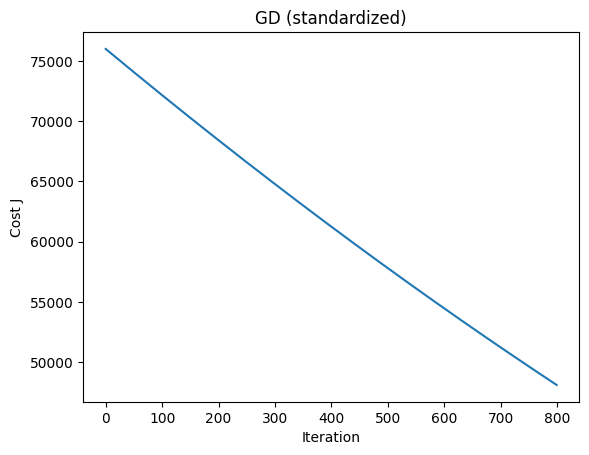

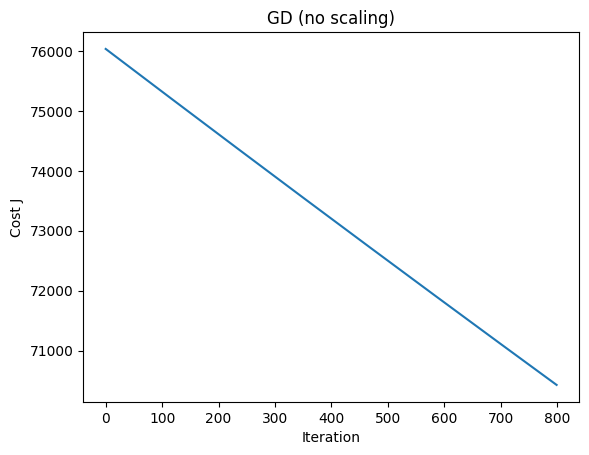

In [5]:
import matplotlib.pyplot as plt
plt.figure(); plt.plot(model['J_hist']); plt.xlabel('Iteration'); plt.ylabel('Cost J'); plt.title('GD (standardized)'); plt.show()
model_noscale = gradient_descent(X, y, alpha=1e-6, iters=800, use_standardize=False)
plt.figure(); plt.plot(model_noscale['J_hist']); plt.xlabel('Iteration'); plt.ylabel('Cost J'); plt.title('GD (no scaling)'); plt.show()

## Day 4 — Learning Rate Analysis

Testing different learning rates spaced approximately 3x apart to observe convergence behavior.

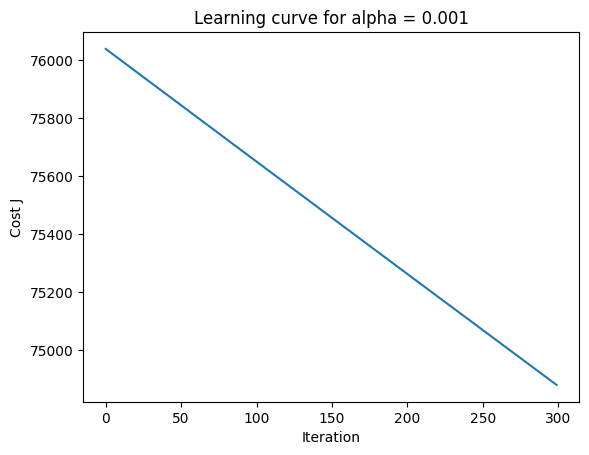

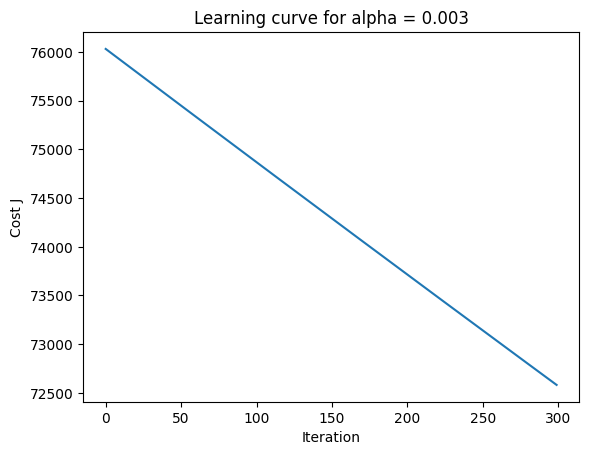

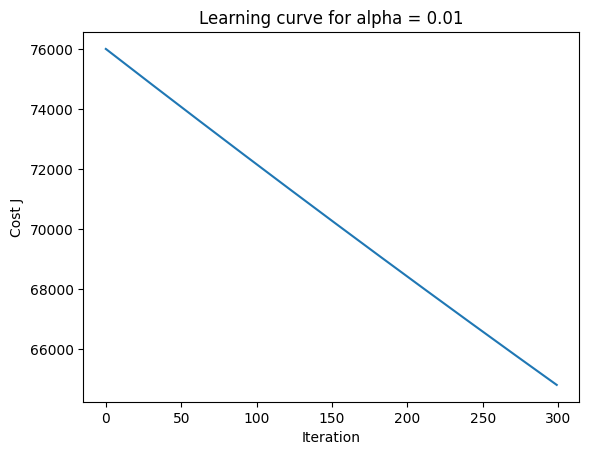

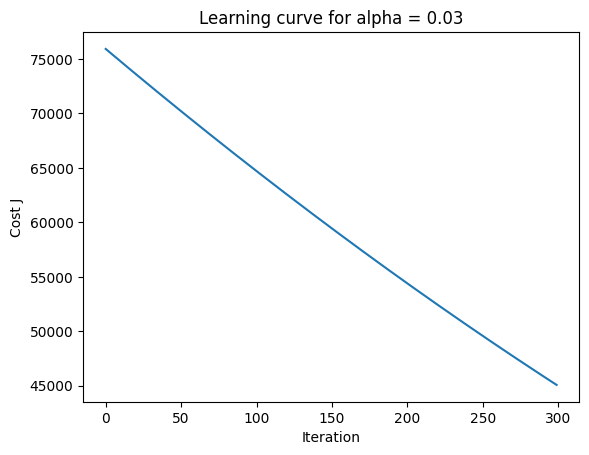

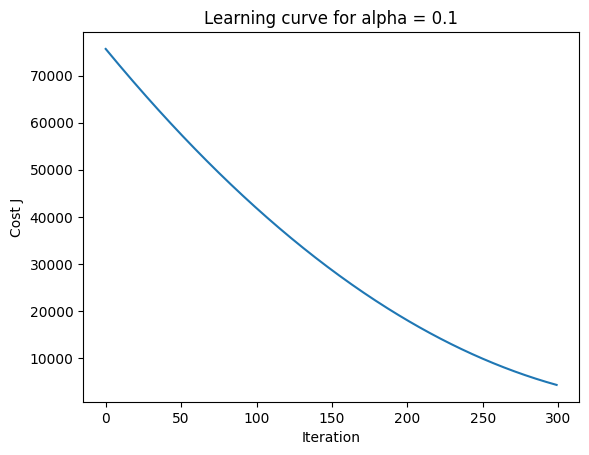

In [6]:
alphas = [1e-3, 3e-3, 1e-2, 3e-2, 1e-1]
for a in alphas:
    out = gradient_descent(X, y, alpha=a, iters=300, use_standardize=True)
    plt.figure(); plt.plot(out['J_hist']); plt.xlabel('Iteration'); plt.ylabel('Cost J'); plt.title(f'Learning curve for alpha = {a}'); plt.show()

## Day 5 — Convergence Analysis

Implementation includes epsilon-based early stopping and confirms cost decreases monotonically with appropriate learning rates.

In [7]:
out_tol = gradient_descent(X, y, alpha=0.05, iters=5000, use_standardize=True, tol=1e-10)
(len(out_tol['J_hist']), out_tol['J_hist'][-1], out_tol['J_hist'][0])

(1001, 347.89143133731193, 75849.0337484186)

## Day 6 — Polynomial Features

Demonstrates polynomial regression using [x, x^2, x^3] features. Feature scaling becomes critical with polynomial terms.

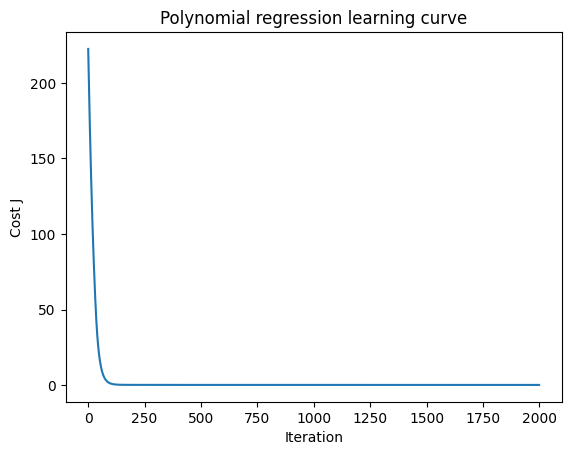

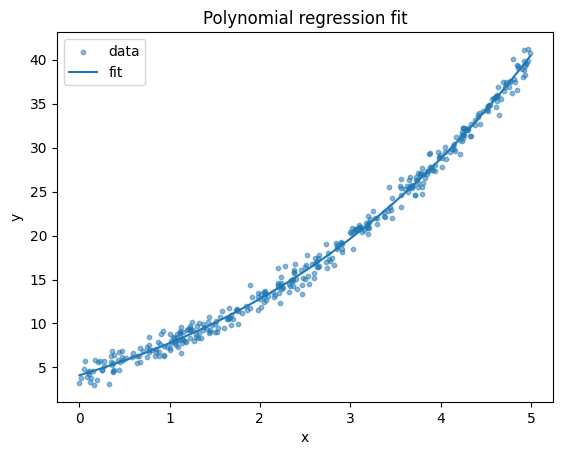

In [8]:
x1 = rng.uniform(0, 5, size=m)
y_curve = 4 + 3*x1 + 0.6*(x1**2) + 0.05*(x1**3) + rng.normal(0, 0.8, size=m)
X_poly = np.column_stack([x1, x1**2, x1**3])
poly_model = gradient_descent(X_poly, y_curve, alpha=0.03, iters=2000, use_standardize=True)
plt.figure(); plt.plot(poly_model['J_hist']); plt.xlabel('Iteration'); plt.ylabel('Cost J'); plt.title('Polynomial regression learning curve'); plt.show()
grid = np.linspace(x1.min(), x1.max(), 200)
Xg = np.column_stack([grid, grid**2, grid**3])
Xg_z = (Xg - poly_model['mu']) / poly_model['sigma']
yhat = Xg_z @ poly_model['w'] + poly_model['b']
plt.figure(); plt.scatter(x1, y_curve, s=10, alpha=0.5, label='data'); plt.plot(grid, yhat, label='fit'); plt.xlabel('x'); plt.ylabel('y'); plt.title('Polynomial regression fit'); plt.legend(); plt.show()

## Day 7 — Model Prediction

Important: Apply the same standardization (mu, sigma) used during training to new input data.

In [9]:
def transform_and_predict(model_dict, X_new):
    if model_dict.get('standardized', False):
        Xz = (X_new - model_dict['mu']) / model_dict['sigma']
    else:
        Xz = X_new
    return Xz @ model_dict['w'] + model_dict['b']
transform_and_predict(model, np.array([[1500,3,10,2],[2200,4,5,2]], dtype=float))

array([ 71.6305652 , 101.09462452])

---

### Key Takeaways

- Prioritize vectorization for performance; use loops only for debugging
- Apply feature scaling when ranges differ significantly (essential for polynomial features)
- Cost function increases indicate learning rate issues or gradient sign errors
- Systematically test learning rates in 3x increments and monitor convergence curves
- Feature engineering often provides better results than increasing model complexity

_End of notebook._